In [78]:
from IPython.core.display import HTML
import requests
#theme_url = "https://raw.githubusercontent.com/ninjasoul/IPython_NB_Config/master/custom.css"
theme_url = "https://raw.githubusercontent.com/ketch/HyperPython/master/custom.css"
rn = requests.get(theme_url)
HTML(rn.text)


# Vision industrielle - TP initiatiation au traitement d'image avec Python

L'objectif de ce TP est de découvrir et d'utiliser des outils de traitement d'images. Le langage de programmation Python sera utilisé, ainsi que les librairies scientifiques suivantes:

    - scikit-image
    - NumPy
    - SciPy
    - matplotlib
    
Ces différentes libairies font partie de la *stack* scientifique disponible pour python. D'autres librairies telles que OpenCV, scikit-learn, pandas vous seront présentées lors des TPs suivants.

## A la fin de ce TP vous devriez être capables

	- d'ouvrir une image à partir d'un fichier
	- d'extraire les contours d'une image en niveau de gris
	- d'effectuer des opérations de filtrage linéaire
	- d'effectuer des opérations morphologiques
	- de détecter la position d'un objet coloré



## Aide 
pour obtenir de l'aide sur une fonction : 
   
    - taper ?nom_fonction 
    - help(nom_fonction)
    
Voici une liste de ressources en ligne qui pourront vous être utiles au cours du TP:

 - IPython notebook introduction: http://opentechschool.github.io/python-data-intro/core/notebook.html
 - Numpy quickstart: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html
 - Numpy pour le traitement d'image http://scikit-image.org/docs/dev/user_guide/numpy_images.html

 

### Exécuter la cellule suivante afin de charger l'ensemble des outils nécessaires

In [79]:
from functools import partial
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib notebook
%matplotlib inline

import pip
pip.main('install imageio'.split())
import imageio
import skimage.morphology
import skimage.segmentation
import skimage.feature


plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.max_open_warning'] = 100

def format_coord(x, y, image):
    x = int(x + 0.5)
    y = int(y + 0.5)
    try:
        val = str(image[y, x])
    except IndexError:
        val = "?"
    return "color={} @ [{}, {}]".format(val, y, x)

def display_image_nb(image, title='', cmap=None):
    fig, ax = plt.subplots(1,1)
    if cmap is None:
        ax.matshow(image)
    else:
        ax.matshow(image, cmap=cmap)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color(image, title=''):
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def draw_rectangle(y1, x1, y2, x2, color='red', ax=None):
    """ Add a rectangle on an image """
    if ax is None:
        ax = pyplot.gca()
    rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

print("OK let's go")

You are using pip version 7.1.2, however version 8.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


OK let's go


## 1. Introduction au tableau numpy pour le traitement d'image


Les images peuvent être représentées sous forme de tableaux multi-dimensionnels. Comme nous sommes en Python, nous utilisons la librairie NumPy (NumPy is the fundamental package for scientific computing with Python: http://www.numpy.org).

Une image en niveaux de gris correspond à un tableau à deux dimensions. Le code suivant permet de créer un tel tableau.

In [80]:
image_niveau_de_gris = np.array([[8, 9, 10, 11], [5, 3, 2, 1], [8, 9, 0, 0]])
print(image_niveau_de_gris)

[[ 8  9 10 11]
 [ 5  3  2  1]
 [ 8  9  0  0]]


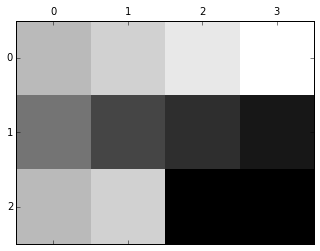

In [81]:
display_image_nb(image_niveau_de_gris)


<span style="color:red">Questions</span>

Quelle est valeur associée au pixel [0, 2]  (i.e ligne 0, colonne 2)




Vous pouvez accéder aux valeurs contenues dans l'image en utilisant la syntaxe suivante :

  image[ligne, colonne]

Compléter le code suivant pour acéder à la valeur associée au pixel de la ligne 0 et de la colonne 2

In [82]:
image_niveau_de_gris[0, 2]

10

Pour représenter une image avec plusieurs canaux (par exemple une image RGB), on utilise une nouvelle dimension.

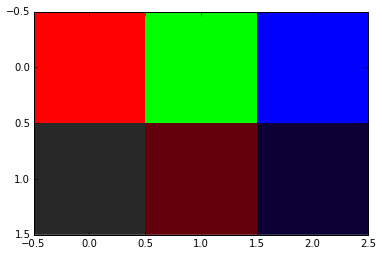

In [83]:
image_rgb = [[[255, 0, 0], [0, 255, 0], [0, 0, 255]], [[40, 40, 40], [100, 0, 10], [10, 0, 50]]]
image_rgb = np.array(image_rgb, dtype=np.uint8)
display_image_color(image_rgb)

Pour sélectionner un canal vous pouvez utiliser la syntaxe suivante: 
    
    image[:, :, 0] qui selectionnera seulement le canal 0 (i.e Red pour une image RGB)
    image[:, :, 1] qui selectionnera le canal 1, etc..
    image[:, :, (0,1)] qui selectionnera le canal 0 et le canal 1
    
Pour remplacer la valeur d'un pixel vous pouvez utiliser la syntaxe suivante:

image[1,5,0] = 8  # qui remplacera le contenu du pixel [1,5] du canal 0 

Vous pouvez aussi remplacer tous les pixels d'un canal

image[:, :, <C-CR>] = 8


<span style="color:red">Questions</span>

Dans l'image *image_rgb* : enlever la composante rouge.

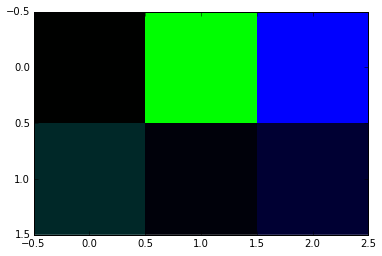

In [84]:
image_rgb[:,:,0] = 0  # enlever le rouge..
display_image_color(image_rgb)


C'est tout pour l'introduction sur les tableaux NumPy. N'hésitez pas à tester la construction de tableau et les opérations par vous-même, ainsi que les quelques fonctions de la cellule suivante.

plus d'info ici:
http://www.scipy-lectures.org/intro/numpy/array_object.html


In [85]:
# Test np.ones

# Test np.random.random

# what is the .shape of an array ?

# 2. Opérations sur les images:


Dans cette partie nous travaillerons avec l'image de référence *chelsea*. 

Vous pouvez néanmoins utiliser l'image que vous souhaitez. Pour charger une image depuis une URL vous pouvez utiliser la fonction imageio.imread.

    import imageio
    souris = imageio.imread('http://static.wamiz.fr/images/animaux/rongeurs/medium/souris.jpg')
    display_image_color(souris)

<IPython.core.display.Javascript object>


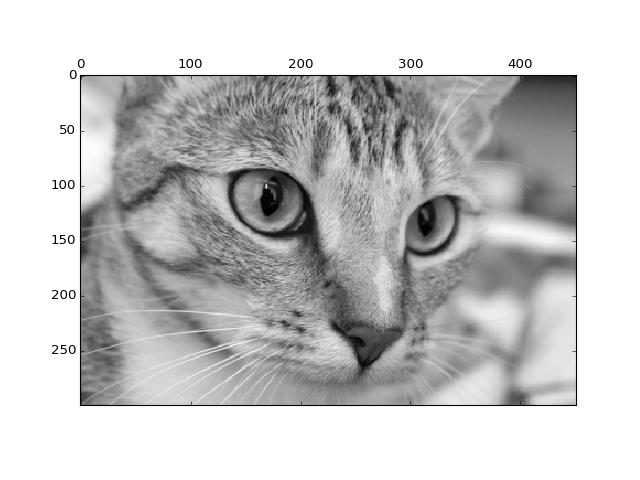

In [86]:
from skimage.data import chelsea
%matplotlib notebook
image = chelsea()
image_nb = skimage.color.rgb2grey(image)
display_image_nb(image_nb)

2.1 Opérateurs pixels à pixels


Calculer la moyenne, max, min et somme de l'image


In [87]:
moyenne = np.mean(image_nb)
max, min = np.max(image_nb), np.min(image_nb)
print("La moyenne est {0:0.2f}".format(moyenne))
print("Minimum = {0:0.3f}, maximum = {1:0.3f}".format(min, max))

La moyenne est 0.46
Minimum = 0.015, maximum = 0.756


Donner la dimension de l'image

In [88]:
dimension = np.shape(image_nb)
print("Dimension = {0}".format(dimension))
print("Nombre de lignes {0}, nombre de colones {1}".format(dimension[0], dimension[1]))

Dimension = (300, 451)
Nombre de lignes 300, nombre de colones 451


Créer le mask binaire (i.e une image binaire) qui vaut 1 partout où l'image *image_nb* a une valeur <= 0.4

<IPython.core.display.Javascript object>


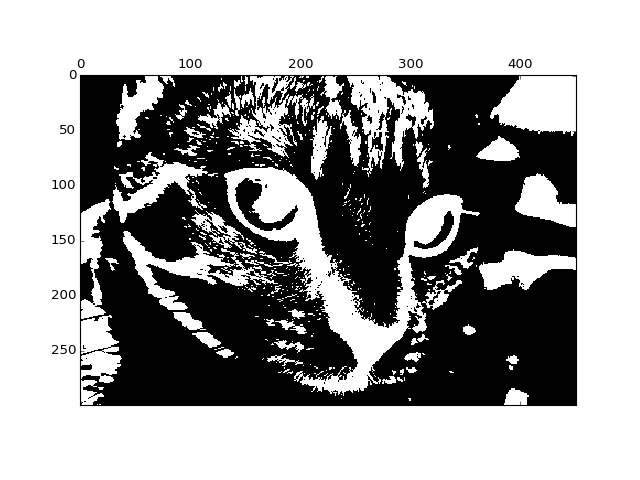

In [89]:
mask = image_nb <= 0.4
display_image_nb(mask)  # blanc == True

Créer une nouvelle image *image_nb_thresholded* dans laquelle les pixels du masque sont mis à 0


<IPython.core.display.Javascript object>


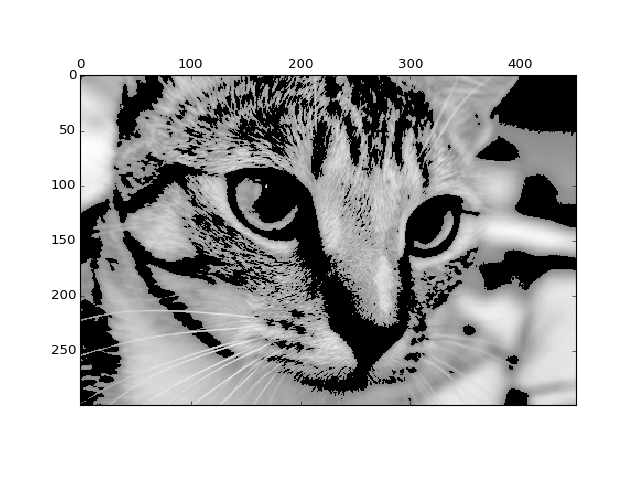

In [90]:
image_nb_thresholded = image_nb.copy()
image_nb_thresholded[mask] = 0
display_image_nb(image_nb_thresholded)

Créer et afficher une nouvelle image dans laquelle les pixels de valeurs comprises entre 0.4 et 0.8 sont mis à zéros

<IPython.core.display.Javascript object>


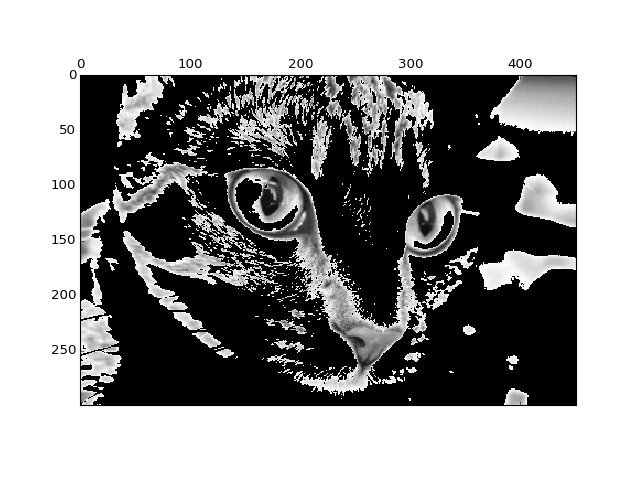

In [91]:
new_image = image_nb.copy()
new_image[(image_nb >= 0.4) & (image_nb <= 0.8)] = 0
display_image_nb(new_image)

*Un peu plus compliqué*

- Créer un masque ne correspondant qu'à la partie basse de l'image

<IPython.core.display.Javascript object>


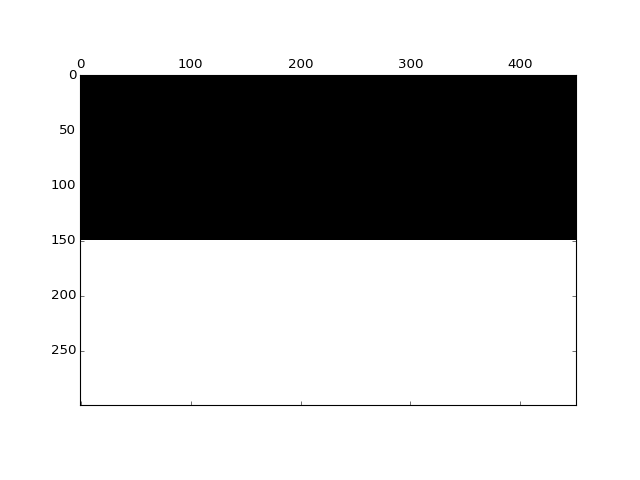

In [92]:
nb_lignes = image_nb.shape[0]
mask = np.zeros(image_nb.shape, dtype=np.bool)
mask[int(nb_lignes/2):, :] = True
display_image_nb(mask)


<IPython.core.display.Javascript object>


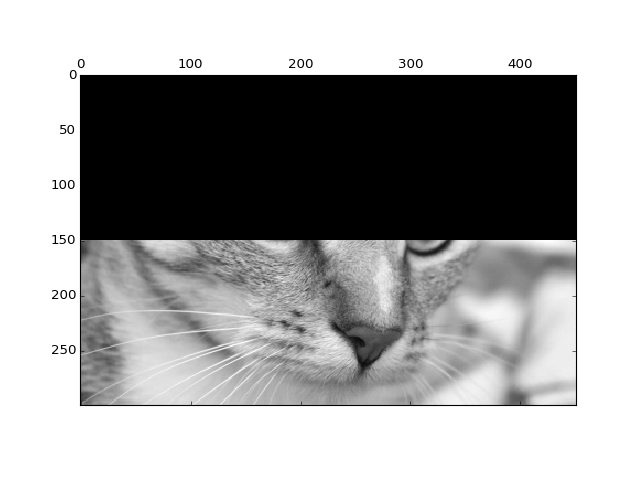

In [93]:
image_partie_basse = image_nb.copy()
image_partie_basse[~mask] = 0  # pour inverser un mask utiliser ~
display_image_nb(image_partie_basse)

- L'utiliser pour calculer la moyenne, max, min, et somme

In [94]:
# partie basse : 
moyenne_partie_basse = np.mean(image_partie_basse)
max_partie_basse = np.max(image_partie_basse)
min_partie_basse = np.min(image_partie_basse)
somme_partie_basse = np.sum(image_partie_basse)

print("Image partie basse (mean = {:.2f}, max = {:.2f}, min = {:.2f}, somme = {:.2f})".format(moyenne_partie_basse, max_partie_basse, 
                                                                              min_partie_basse, somme_partie_basse))


Image partie basse (mean = 0.24, max = 0.73, min = 0.00, somme = 32421.62)


- Inverser la partie basse de l'image

<IPython.core.display.Javascript object>


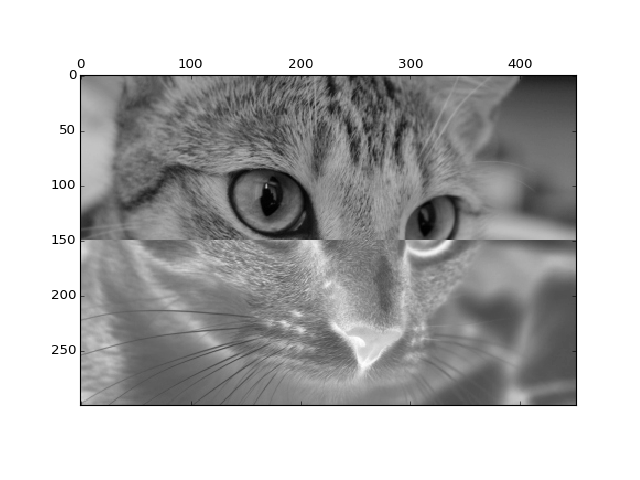

In [95]:
image_avec_partie_basse_inversee = image_nb.copy()
image_avec_partie_basse_inversee[mask] = np.abs(1 - image_nb[mask])
display_image_nb(image_avec_partie_basse_inversee)

## 2.2 Filtrage

Filtrer l'image *image_nb* avec les filtres suivants :

- un filtre moyenneur
- un filtre laplacien
- un filtre de Sobel
- utiliser un filtre de canny pour extraire les contours

Les fonctions qui peuvent vous être utiles sont:

    scipy.ndimage.convolve, skimage.filters.sobel, skimage.feature.canny

<IPython.core.display.Javascript object>


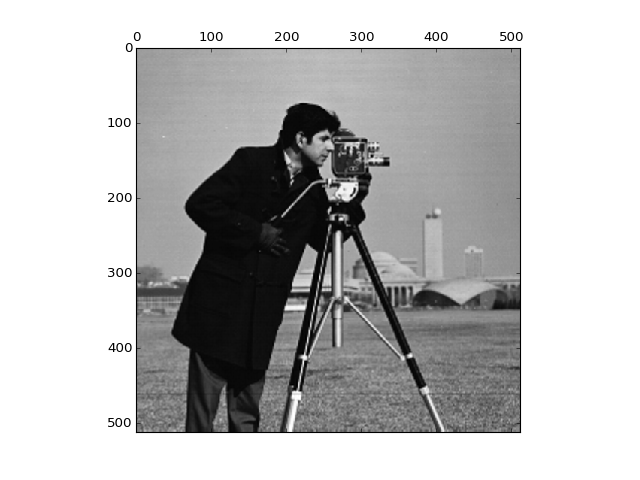

In [96]:
image = skimage.data.camera()
image_nb = skimage.color.rgb2grey(image)
display_image_nb(image_nb)

## 2.3 Opérateurs morphologiques

- Effectuer une dilatation et une ouverture morphologiques  à l'aide d'un élément structurant de type disk (3,3)
- Effecture une érosion à l'aide d'un élément structurant donné par le tableau suivant : 

0 1 0
1 1 1
0 1 0


les fonctions qui peuvent vous être utiles:

    skimage.morphology.disk, skimage.morphology.opening, skimage.morphology.dilate, skimage.morphology.erosion


In [97]:
a = 8
print(a)
for i in range(10):
    print(i)

8
0
1
2
3
4
5
6
7
8
9


## 3. Application

Le but de cette section est de mettre en application les différentes techniques que vous avez vu jusqu'à présent.

Objectif: détecter où se trouve le ballon dans l'image suivante

![alt text](http://srand.fr/red_ball.png "image to find")


Cette image est extraite du jeu de données disponible sur le site: http://www.iai.uni-bonn.de/~kleind/tracking/index.htm.
Nous aurons l'occasion de réutiliser ce type de jeu de données dans les prochains TPs.


Votre objectif

    - Trouver où se trouve la balle dans l'image
    
    
Un exemple de résultat: 


![alt text](http://srand.fr/red_ball_result.png "good result")

    
Voici une liste de fonction qui peut vous être utile:

     skimage.segmentation.mark_boundaries, skimage.color.rgb2lab, skimage.segmentation.clear_border, skimage.morphology.erosion, dilation, opening, closing, skimage.measure.label, skimage.measure.regionprops
     
     
C'est parti.




<IPython.core.display.Javascript object>


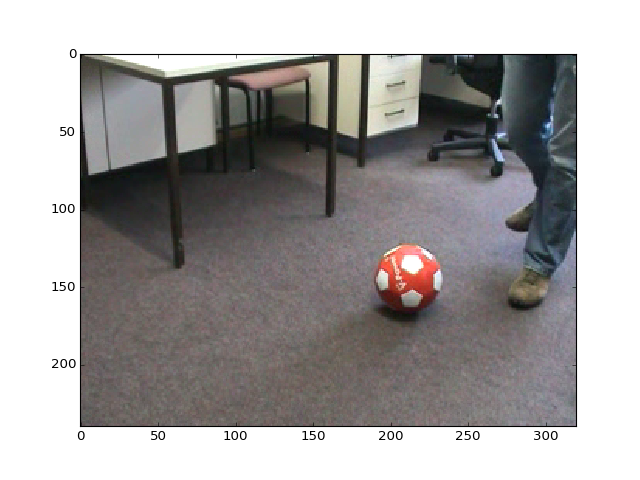

In [98]:
image = imageio.imread('http://srand.fr/red_ball.png')
display_image_color(image)

## Bonus:

- Calculer l'histogramme de l'image lena (skimage.data.lena())
- Calculer l'histogramme de l'image chelsea (skimage.data.chelsea())

ressources:

 - http://scikit-image.org/docs/dev/auto_examples/plot_windowed_histogram.html
 

## Bonus bis:

Charger l'image coins (skimage.data.coins())

- Afficher la pièce de la première colonne, dernière ligne.
- Calculer l'histogramme correspondant à cette pièce.
- Calculer l'histogramme normalisé correspondant à cette pièce, et l'afficher à l'aide d'un graphique.
